In [1]:
import os
import pandas as pd
import numpy as np
import json
from itertools import chain
import datetime
from matplotlib import pyplot as plt

# In this analysis we evaluate how the civil unrest in the country has contributed towards the spread of the Covid-19 Virus

In [2]:
# load protest dataset
parse_event = lambda event: {'id': event['event_id'], 'date': event['event_date'], 'location': event['event_location'], 'attendees': event['event_attendees'], 'primary_url': event['event_primary_url']}
parse_event_tags = lambda event: {'id': event['event_id'], 'tags': event['event_tags'].split('; ')}

event_data = []
event_tags = []
event_tag_types = []
with open(os.path.join('.', 'data', 'count-love-protest-data', 'data.json'), 'r') as protest_data_fd:
    data = json.load(protest_data_fd)
    event_data = list(map(parse_event, data['events']))
    
    event_tags_tmp = list(map(parse_event_tags, data['events']))
    for entry in event_tags_tmp:
        current_event_tags = [{'event_id': entry['id'], 'tag': tag} for tag in entry['tags']]
        event_tags = [*current_event_tags, *event_tags]
    
    for key, data in data['tags'].items():
        event_tag_types_tmp = [{'tag_type': key, 'tag': tag} for tag in data]
        event_tag_types = [*event_tag_types, *event_tag_types_tmp]
        
    print("total events %s" % (len(event_data)) )

event_df = pd.DataFrame(event_data)
event_tags_df = pd.DataFrame(event_tags)
event_tags_type_df = pd.DataFrame(event_tag_types)
tags_complete_df = pd.merge(event_tags_df, event_tags_type_df, how='left', on='tag')
complete_event_data_df = pd.merge(event_df.rename(columns={'id':'event_id'}), tags_complete_df, on='event_id')

# add columns for year and month
complete_event_data_df['month'] = complete_event_data_df['date'].map(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d').strftime('%B'))
complete_event_data_df['year'] = complete_event_data_df['date'].map(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d').strftime('%Y'))

total events 42347


In [3]:
# select only events by their main category and drop any rows with no values
events_by_category = complete_event_data_df.loc[complete_event_data_df['tag_type'] == 'category', :].dropna(inplace=False)

#drop any duplicate entries if any
duplicate_entries = events_by_category.loc[events_by_category.duplicated(['event_id', 'tag']), :].index
if len(duplicate_entries) > 0:
    events_by_category = events_by_category.drop(index=duplicate)

### During the year 2020, the US registered record numbers of Civil Rights related events compared to previous years

['Civil Rights' 'Collective Bargaining' 'Education' 'Environment'
 'Executive' 'Guns' 'Healthcare' 'Immigration' 'International' 'Judicial'
 'Legislative' 'Other']
['2017' '2018' '2019' '2020' '2021']


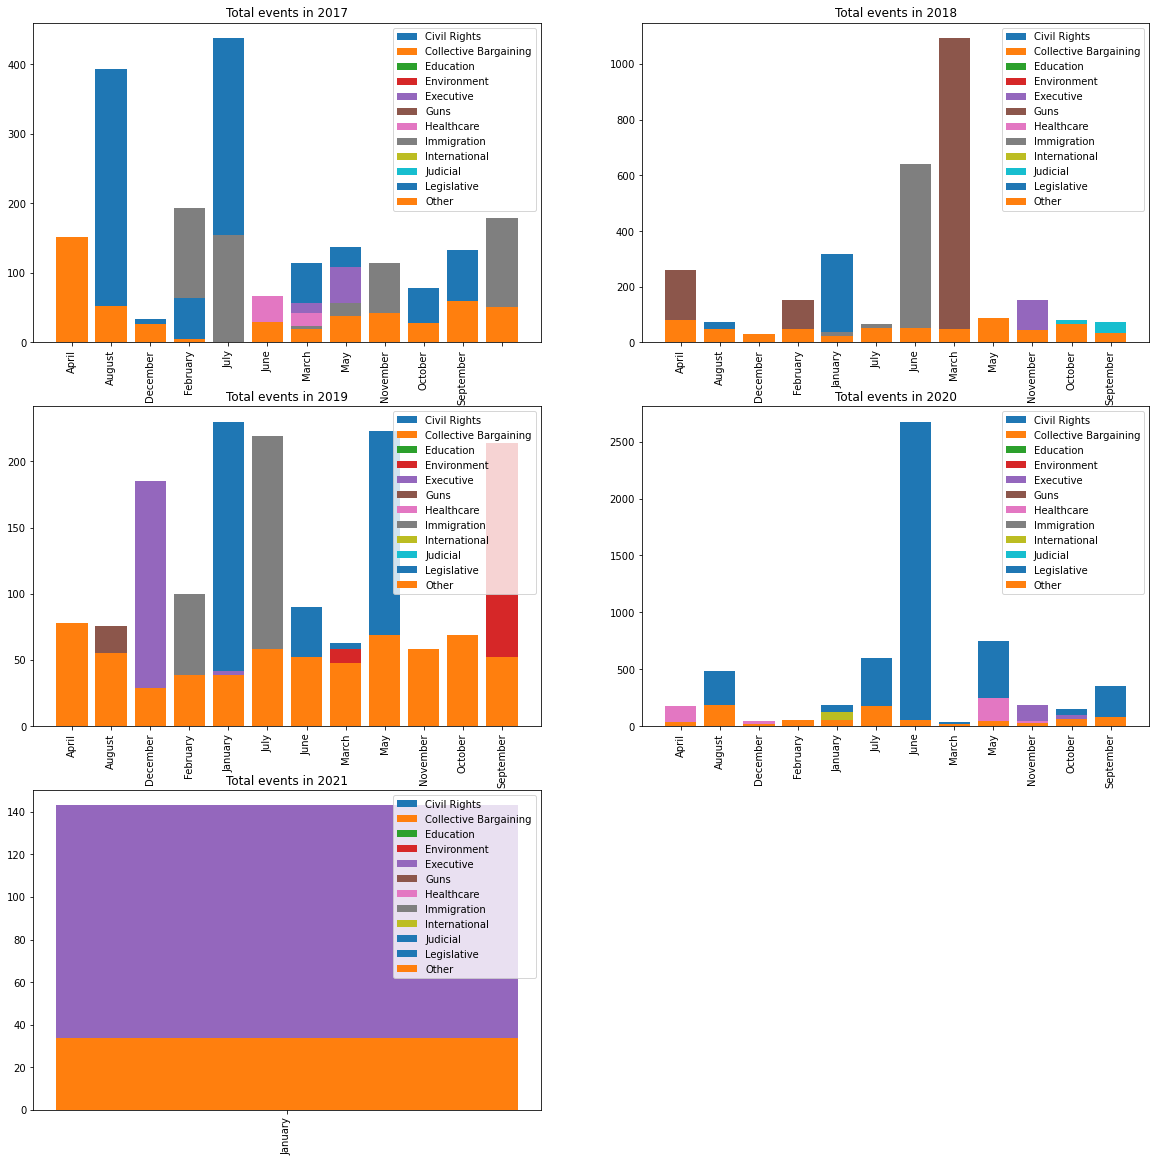

In [39]:
total_events_by_year_month_tag = events_by_category.groupby(['year', 'month', 'tag']).count()[['event_id']] \
    .rename(columns={'event_id': 'total events'}) \
    .reset_index()

print(total_events_by_year_month_tag.tag.unique())
print(total_events_by_year_month_tag.year.unique())
plt.figure(figsize=(20,20))

years = total_events_by_year_month_tag.year.unique()
for year_i in range(len(years)):
    year = years[year_i]
    current_plot_index = year_i + 1
    ax = plt.subplot(3, 2, current_plot_index)

    for tag in total_events_by_year_month_tag.tag.unique():
        subset = total_events_by_year_month_tag.loc[(total_events_by_year_month_tag['year'] == year) & (total_events_by_year_month_tag['tag'] == tag), :]

        ax.bar(subset['month'], subset['total events'], label=f"{tag}")
        ax.set_xticklabels(subset['month'], rotation=90)
        ax.set_title(f"Total events in {year}")
        ax.legend()